# Ribonanza 2

A second approach to the [Stanford Ribonanza problem](https://www.kaggle.com/competitions/stanford-ribonanza-rna-folding/) that builds off the first approach.

Major differences:
- use of different model architecture
- use of only filtered data (data in which SN_filter == 1)

## Setup

### Filesystem Setup

Your project directory should look like this:

- `(project directory)`
    - `ribonanza2.ipynb`
    - `train_data.csv`

`train_data.csv` is the only file necessary, and it can be downloaded from the kaggle competition linked in the description.

### Code Setup

In [15]:
# imports
import tensorflow as tf
import keras
import keras.layers as layers
import keras.optimizers as optimizers
import keras.metrics as metrics
import pandas
import numpy as np
from tqdm import tqdm
import seaborn
import os

In [2]:
# constants

# according to kaggle, this is the maximum # of reactivites to be used
NUM_REACTIVITIES = 457

# there are 4 different bases (AUCG)
NUM_BASES = 4

## Data Preprocessing

### Filter Data

In [3]:
def filter_data(out: str, key: str, value: str, file_name: str, force: bool):
    """
    Filters a file to only take datapoints
    whose values of `key` are `value`.

    Parameters:
        - out: str - the name of the file that will store the filtered datapoints
        - key: str - the name of the key to look at
        - value: str - the value that the key should have
        - file_name: str - the name of the file that contains all the datapoints.
        - force: bool - whether or not to force re-processing of the data (if False and `out` already exists, no work will be done)
    """
    if os.path.exists(out) and not force:
        print("File already exists, not doing any work")
        return

    count = 0

    # count how many lines we have in total
    with open(file_name) as file:
        line = file.readline()  # ignore the header
        line = (
            file.readline()
        )  # take the first line since we increment count in the loop
        while line != "":
            count += 1
            line = file.readline()

    # use that knowledge for a progress bar
    with open(file_name, "r") as file, open(out, "w") as outfile:
        # write the header
        header = file.readline()
        outfile.write(header)

        # get what index the SN_filter is
        SN_idx = header.split(",").index(key)

        # only take the approved filtered lines
        for _ in tqdm(range(count)):
            line = file.readline()
            temp = line.split(",")
            if temp[SN_idx] == value:
                outfile.write(line)


def filter_train_data(force: bool = False):
    """
    Filters the immense train_data.csv to only take datapoints
    whose SN_filter (Signal to Noise filter) is 1. In other words,
    we only take good reads. These filtered datapoints are then
    written to the file provided

    Parameters:
        - force: bool - whether or not to force re-processing of the data (if False and `out` already exists, no work will be done)
    """
    filter_data("train_data_filtered.csv", "SN_filter", "1", "train_data.csv", force)


def filter_2A3(force: bool = False):
    """
    Only take the 2A3 points

    Parameters:
        - force: bool - whether or not to force re-processing of the data (if False and `out` already exists, no work will be done)
    """
    filter_data(
        "train_data_2a3.csv",
        "experiment_type",
        "2A3_MaP",
        "train_data_filtered.csv",
        force,
    )


def filter_DMS(force: bool = False):
    """
    Only take the DMS points

    Parameters:
        - force: bool - whether or not to force re-processing of the data (if False and `out` already exists, no work will be done)
    """
    filter_data(
        "train_data_dms.csv",
        "experiment_type",
        "DMS_MaP",
        "train_data_filtered.csv",
        force,
    )

In [4]:
# filter our data
filter_train_data()

File already exists, not doing any work


In [5]:
# take the 2a3 points
filter_2A3()

File already exists, not doing any work


In [6]:
# take the dms points
filter_DMS()

File already exists, not doing any work


### Convert Data to Inputs and Outputs

In [7]:
# encode inputs as
# A : [1, 0, 0, 0]
# U : [0, 1, 0, 0]
# C : [0, 0, 1, 0]
# G : [0, 0, 0, 1]
base_map = {
    "A": np.array([1, 0, 0, 0]),
    "U": np.array([0, 1, 0, 0]),
    "C": np.array([0, 0, 1, 0]),
    "G": np.array([0, 0, 0, 1]),
}

In [8]:
def preprocess_csv(out: str, file_name: str, force: bool = False):
    """
    Preprocess the csv and save the preprocessed data as a .npz file

    Parameters:
        - out: str - the name of the file to save the arrays to
        - file_name: str - the name of the input csv file
        - force: bool - whether or not to force re-processing of the data (if False and `out` already exists, no work will be done).
                Defaults to `False`
    """
    if os.path.exists(out) and not force:
        print("File already exists, not doing any work")
        return

    df = pandas.read_csv(file_name)

    inputs = np.zeros((len(df), NUM_REACTIVITIES, NUM_BASES))
    outputs = np.zeros((len(df), NUM_REACTIVITIES))
    output_masks = np.ones((len(df), NUM_REACTIVITIES), dtype=np.bool_)

    for index in tqdm(range(len(df))):
        row = df.iloc[index]

        # get the sequence
        seq_len = len(row["sequence"])

        # map the base to its one-hot encoding
        inputs[index, :seq_len] = np.array(
            list(map(lambda letter: base_map[letter], row["sequence"]))
        )

        # get all the reactivities and whether or not they are nan
        reactivities = np.array(
            list(
                map(
                    lambda seq_idx: row["reactivity_" + str(seq_idx + 1).rjust(4, "0")],
                    range(seq_len),
                )
            )
        )
        nan_locats = np.isnan(reactivities)

        # where it is nan, store True, else false
        output_masks[index, :seq_len] = nan_locats

        # where it is not nan, store the reactiviy, else 0
        outputs[index, :seq_len] = np.where(nan_locats == False, reactivities, 0.0)

    # save the outputs
    np.savez_compressed(out, inputs=inputs, outputs=outputs, output_masks=output_masks)

In [9]:
preprocess_csv("train_data_2a3_preprocessed.npz", "train_data_2a3.csv")

File already exists, not doing any work


In [10]:
preprocess_csv("train_data_dms_preprocessed.npz", "train_data_dms.csv")

File already exists, not doing any work


### Load the desired dataset

In [11]:
desired_dataset = "2a3"  # either "2a3" or "dms"

# load the npz file
npz_file = np.load(f"train_data_{desired_dataset}_preprocessed.npz")

# stored inputs, outputs, and output_masks
inputs, outputs, output_masks = (
    npz_file["inputs"],
    npz_file["outputs"],
    npz_file["output_masks"],
)

# close the npz file
npz_file.close()

### Visualize

In [ ]:
visualize = True

In [12]:
if visualize:
    visualized_items = []
    for i in tqdm(range(len(outputs))):
        for x in range(NUM_REACTIVITIES):
            if not output_masks[i, x]:
                visualized_items.append(outputs[i, x])
    visualized_items = np.array(visualized_items)
else:
    print("Not visualizing. Set `visualize` to `True` to visualize data")

  0%|          | 0/210992 [00:00<?, ?it/s]

100%|██████████| 210992/210992 [00:18<00:00, 11546.09it/s]


<Axes: ylabel='Count'>

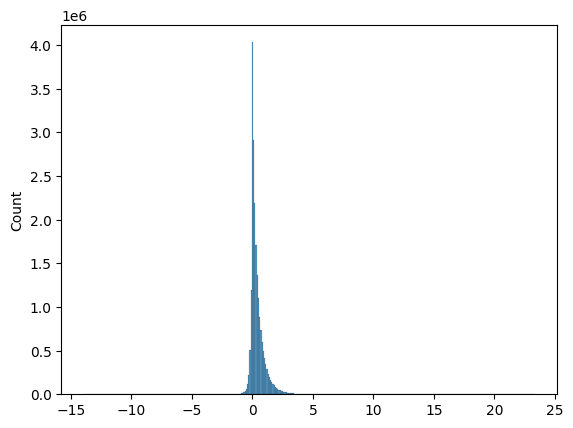

In [13]:
if visualize:
    seaborn.histplot(visualized_items, stat="count", binwidth=0.1)
else:
    print("Not visualizing. Set `visualize` to `True` to visualize data")

## Model

In [18]:
def make_baseline_model():
    inputs = layers.Input((NUM_REACTIVITIES, NUM_BASES))
    
    x = layers.Conv1D(4, 16, 1, padding='same', activation='relu')(inputs)
    x = layers.Conv1D(4, 16, 1, padding='same', activation='relu')(x)
    x = layers.Conv1D(4, 16, 2, padding='same', activation='relu')(x)
    x = layers.Flatten()(x)
    x = layers.Dense(1024, activation="relu", activity_regularizer="l2")(x)

    x = layers.Dense(NUM_REACTIVITIES)(x)

    return keras.Model(inputs=inputs, outputs=x)


In [19]:
model = make_baseline_model()
model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 457, 4)]          0         
                                                                 
 conv1d_3 (Conv1D)           (None, 457, 4)            260       
                                                                 
 conv1d_4 (Conv1D)           (None, 457, 4)            260       
                                                                 
 conv1d_5 (Conv1D)           (None, 229, 4)            260       
                                                                 
 flatten_1 (Flatten)         (None, 916)               0         
                                                                 
 dense_2 (Dense)             (None, 1024)              939008    
                                                                 
 dense_3 (Dense)             (None, 457)               4684

In [20]:
model.compile(optimizers.Adam(1e-4))

## Train

In [ ]:
## TODO - use custom trianing loop to not incorporate the ones that are masked